<a href="https://colab.research.google.com/github/lucacamus13/Tesis/blob/main/An%C3%A1lisis_econom%C3%A9trico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de la base de datos

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

def cargar_datos_maestros():
    """
    Carga la base de datos maestra desde GitHub.
    Hoja: 'resampleado'
    Rango: Columna A (Fecha), B-P (Variables).
    Fila de datos: Comienza en fila 3 (Excel). -> Header debe ser Fila 2 (index 1).
    """
    url = "https://github.com/lucacamus13/Tesis/raw/main/data/Base_Datos_Maestra_Completa%20.xlsx"
    print(f"📂 Cargando datos desde: {url}")

    try:
        # Leer Excel
        # Asumimos que la nueva base consolidada tiene la primera hoja correcta y encabezados en la primera fila (0)
        df = pd.read_excel(url)

        # Renombrar columna de fecha si es necesario (asumiendo que la 1ra es fecha)
        # A veces pandas la llama "Unnamed: 0" si está vacía
        if 'Fecha' not in df.columns and 'Date' not in df.columns:
            df.rename(columns={df.columns[0]: 'Fecha'}, inplace=True)

        # Convertir a datetime y set index
        col_fecha = df.columns[0]
        df[col_fecha] = pd.to_datetime(df[col_fecha], errors='coerce')
        df = df.dropna(subset=[col_fecha]) # Eliminar filas sin fecha
        df = df.set_index(col_fecha).sort_index()

        print(f"   ✅ Datos cargados exitosamente.")
        return df
    except Exception as e:
        print(f"   ❌ Error cargando datos: {e}")
        return None

def resumen_general(df):
    """
    Muestra un resumen de la base de datos cargada.
    """
    print("\n📋 RESUMEN GENERAL DE LA BASE DE DATOS")
    print("="*60)
    print(f"📌 Dimensiones: {df.shape[0]} observaciones x {df.shape[1]} variables")
    print(f"� Rango Temporal: {df.index.min().date()} a {df.index.max().date()}")
    print("\n📌 Variables Identificadas:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i}. {col} ({df[col].count()} obs)")

    print("\n📌 Primeras 5 filas:")
    print(df.head())

def analizar_serie_individual(df, nombre_serie):
    """
    Analiza una serie específica: Estadísticas y Gráficos.
    """
    if nombre_serie not in df.columns:
        print(f"\n⚠️ Error: La variable '{nombre_serie}' no existe en el DataFrame.")
        print(f"   Variables disponibles: {df.columns.tolist()}")
        return

    print(f"\n� ANÁLISIS INDIVIDUAL: {nombre_serie}")
    print("="*60)

    serie = df[nombre_serie].dropna()

    # Estadísticas
    desc = serie.describe()
    print(f"📊 Estadísticas Descriptivas:")
    print(desc)

    # Gráficos
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Line Plot
    serie.plot(ax=axes[0], linewidth=2, title=f"Evolución: {nombre_serie}")
    axes[0].grid(True)

    # Histograma
    sns.histplot(serie, kde=True, ax=axes[1]).set_title(f"Distribución: {nombre_serie}")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Exponer df al ámbito global para siguientes bloques en Colab
df = None

if __name__ == "__main__":
    print("📊 ANÁLISIS ECONOMÉTRICO: IMPACTO SHOCKS FED -> LATAM")
    print("="*60)

    # 1. Cargar Datos Globalmente
    df = cargar_datos_maestros()

    if df is not None:
        # 2. Resumen General
        resumen_general(df)
        print("\n✅ DataFrame 'df' cargado en memoria. Listo para el siguiente bloque.")
    else:
        print("\n❌ Error: No se pudo cargar el DataFrame.")


📊 ANÁLISIS ECONOMÉTRICO: IMPACTO SHOCKS FED -> LATAM
📂 Cargando datos desde: https://github.com/lucacamus13/Tesis/raw/main/data/Base_Datos_Maestra_Completa%20.xlsx
   ✅ Datos cargados exitosamente.

📋 RESUMEN GENERAL DE LA BASE DE DATOS
📌 Dimensiones: 804 observaciones x 19 variables
� Rango Temporal: 1959-01-01 a 2025-12-01

📌 Variables Identificadas:
   1. PCEPI (801 obs)
   2. INDPRO (801 obs)
   3. RBUSBIS (381 obs)
   4. FF4 (804 obs)
   5. FF1 (804 obs)
   6. VIX (432 obs)
   7. SP500 (432 obs)
   8. EMBI_Argentina (219 obs)
   9. EMBI_Brasil (219 obs)
   10. EMBI_Chile (219 obs)
   11. EMBI_Mexico (219 obs)
   12. Actividad_Argentina (262 obs)
   13. Actividad_Chile (356 obs)
   14. Actividad_Brasil (272 obs)
   15. Actividad_Mexico (392 obs)
   16. TCR_Argentina (383 obs)
   17. TCR_Chile (383 obs)
   18. TCR_Brasil (383 obs)
   19. TCR_Mexico (383 obs)

📌 Primeras 5 filas:
             PCEPI   INDPRO  RBUSBIS  FF4  FF1  VIX  SP500  EMBI_Argentina  \
Fecha                      

In [24]:
df

,PCEPI,INDPRO,RBUSBIS,FF4,FF1,VIX,SP500,EMBI_Argentina,EMBI_Brasil,EMBI_Chile,EMBI_Mexico,Actividad_Argentina,Actividad_Chile,Actividad_Brasil,Actividad_Mexico,TCR_Argentina,TCR_Chile,TCR_Brasil,TCR_Mexico
Fecha,,,,,,,,,,,,,,,,,,,
1959-01-01,15.164,21.9998,NaN,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,15.179,22.4306,NaN,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,15.189,22.7538,NaN,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-04-01,15.219,23.2384,NaN,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-05-01,15.227,23.5885,NaN,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01,127.283,101.6019,108.69,0.000,0.0000,15.750000,6408.949475,7.594249,1.964722,1.062181,2.532845,152.449508,112.807635,108.65847,105.133303,126.14,98.99,107.93,127.70
2025-09-01,127.625,101.6729,108.26,-0.025,0.0050,15.773333,6584.018090,10.956898,1.868881,1.009349,2.237666,153.382018,NaN,NaN,NaN,120.98,99.34,109.78,128.96
2025-10-01,NaN,NaN,NaN,0.085,0.0000,18.086522,6735.691725,9.918901,1.966036,0.996911,2.202659,152.839848,NaN,NaN,NaN,121.19,100.20,109.75,130.13


# Analisis de series de tiempo

Variables Identificadas:
   1. PCEPI
   2. INDPRO
   3. RBUSBIS
   4. FF4
   5. FF1
   6. VIX
   7. SP500
   8. EMBI_Argentina
   9. EMBI_Brasil
   10. EMBI_Chile
   11. EMBI_Mexico
   12. Actividad_Argentina_Nivel
   13. Actividad_Chile_Nivel
   14. Actividad_Brasil_Nivel
   15. Actividad_Mexico_Nivel
   16. TCR_Argentina
   17. TCR_Chile
   18. TCR_Brasil
   19. TCR_Mexico


🔍 ANÁLISIS DETALLADO: TCR_Mexico


/tmp/ipython-input-1461297124.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie = df[nombre_serie].fillna(method='ffill').fillna(method='bfill')


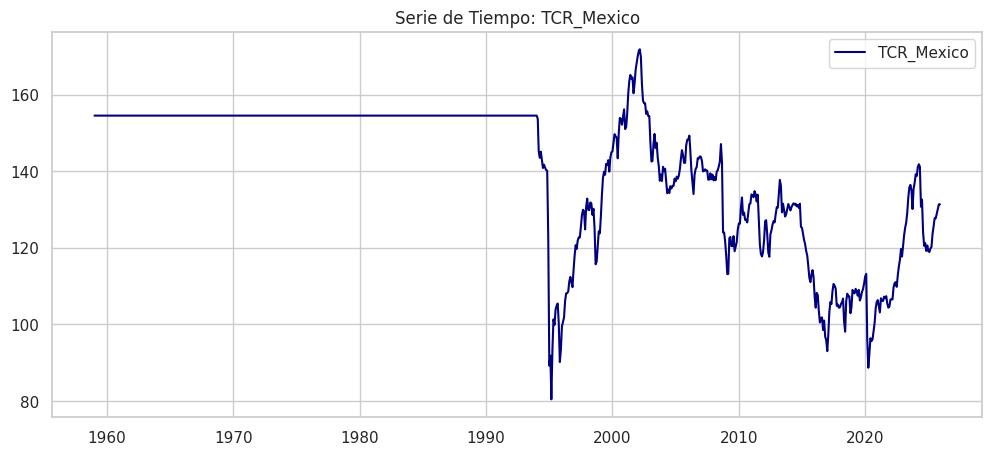


🧪 1. Test de Dickey-Fuller Aumentado (ADF)
----------------------------------------
   Estadístico ADF: -2.5004
   p-value:         0.1154
   Valores Críticos:
      1%: -3.4386
      5%: -2.8652
      10%: -2.5687
   ⚠️ Conclusión: La serie es NO ESTACIONARIA (Tiene raíz unitaria)

📉 2. Descomposición Estacional
----------------------------------------


/tmp/ipython-input-1461297124.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie = serie.fillna(method='ffill')


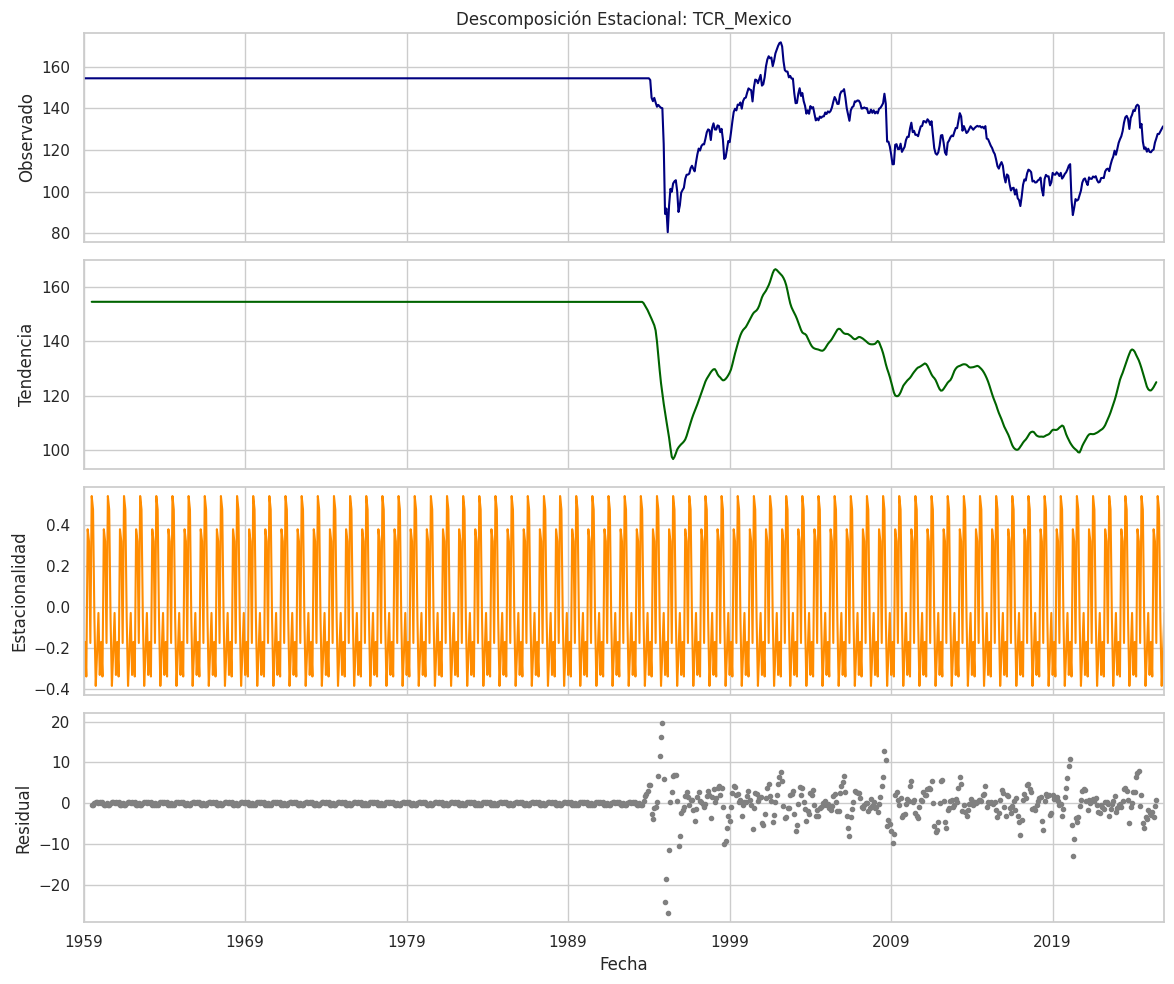


📊 3. Correlogramas (ACF y PACF)
----------------------------------------


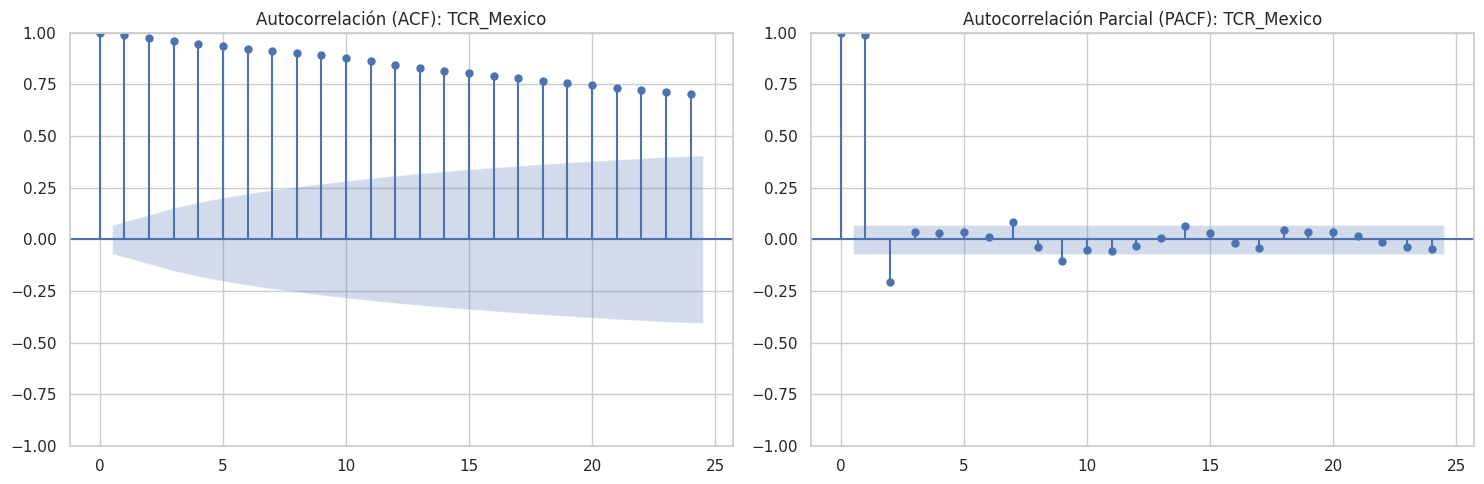

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose # Añadir esta importación

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

def analizar_serie_detallado(df, nombre_serie):
    """
    Realiza un análisis descriptivo detallado de una serie:
    1. Gráfico de la Serie
    2. Test de Dickey-Fuller Aumentado (ADF)
    3. Descomposición Estacional (Seasonal Decompose)
    4. Correlogramas (ACF y PACF)
    """
    if df is None:
        print("❌ Error: El DataFrame 'df' es None. Asegúrate de cargar los datos primero.")
        return

    if nombre_serie not in df.columns:
        print(f"\n⚠️ Error: La variable '{nombre_serie}' no existe en el DataFrame.")
        print(f"   Variables disponibles: {df.columns.tolist()}")
        return

    print(f"\n🔍 ANÁLISIS DETALLADO: {nombre_serie}")
    print("="*60)

    # Obtener serie y rellenar NaNs (necesario para descomposición)
    serie = df[nombre_serie].fillna(method='ffill').fillna(method='bfill')

    if serie.empty:
        print("   ⚠️ La serie está vacía.")
        return

    # ---------------------------------------------------------
    # 1. Graficar la Serie
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(serie, label=nombre_serie, color='navy')
    plt.title(f'Serie de Tiempo: {nombre_serie}')
    plt.legend()
    plt.show()

    # ---------------------------------------------------------
    # 2. Test de Dickey-Fuller Aumentado (ADF)
    # ---------------------------------------------------------
    print(f"\n🧪 1. Test de Dickey-Fuller Aumentado (ADF)")
    print("-" * 40)

    try:
        result_adf = adfuller(serie.dropna())

        print(f"   Estadístico ADF: {result_adf[0]:.4f}")
        print(f"   p-value:         {result_adf[1]:.4f}")
        print("   Valores Críticos:")
        for key, value in result_adf[4].items():
            print(f"      {key}: {value:.4f}")

        if result_adf[1] < 0.05:
            print("   ✅ Conclusión: La serie es ESTACIONARIA (Rechaza H0 al 5%)")
        else:
            print("   ⚠️ Conclusión: La serie es NO ESTACIONARIA (Tiene raíz unitaria)")
    except Exception as e:
        print(f"   ❌ Error en ADF: {e}")

    # ---------------------------------------------------------
    # 3. Seasonal Decompose
    # ---------------------------------------------------------
    print(f"\n📉 2. Descomposición Estacional")
    print("-" * 40)

    try:
        # Intentar inferir frecuencia si no existe
        if serie.index.freq is None:
            serie = serie.asfreq('MS')
            serie = serie.fillna(method='ffill')

        decomposition = seasonal_decompose(serie, model='additive')

        fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

        decomposition.observed.plot(ax=axes[0], legend=False, color='navy')
        axes[0].set_ylabel('Observado')
        axes[0].set_title(f'Descomposición Estacional: {nombre_serie}')

        decomposition.trend.plot(ax=axes[1], legend=False, color='darkgreen')
        axes[1].set_ylabel('Tendencia')

        decomposition.seasonal.plot(ax=axes[2], legend=False, color='darkorange')
        axes[2].set_ylabel('Estacionalidad')

        decomposition.resid.plot(ax=axes[3], legend=False, color='gray', linestyle='None', marker='.')
        axes[3].set_ylabel('Residual')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"   ❌ Error en descomposición estacional: {e}")

    # ---------------------------------------------------------
    # 4. Correlogramas (ACF y PACF)
    # ---------------------------------------------------------
    print(f"\n📊 3. Correlogramas (ACF y PACF)")
    print("-" * 40)

    try:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Autocorrelación (ACF)
        plot_acf(serie.dropna(), ax=axes[0], lags=24, title=f"Autocorrelación (ACF): {nombre_serie}")

        # Autocorrelación Parcial (PACF)
        plot_pacf(serie.dropna(), ax=axes[1], lags=24, title=f"Autocorrelación Parcial (PACF): {nombre_serie}")

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"   ❌ Error generando correlogramas: {e}")

# -----------------------------------------------------------
# EJECUCIÓN (Asumiendo que 'df' ya existe)
# -----------------------------------------------------------
# 👇 CAMBIA EL NOMBRE DE LA VARIABLE AQUÍ
SERIE_A_ANALIZAR = 'TCR_Mexico'

# Verificación de seguridad por si corres este script solo
if 'df' in locals():
    analizar_serie_detallado(df, SERIE_A_ANALIZAR)
else:
    print("⚠️ El DataFrame 'df' no está definido.")
    print("   Ejecuta primero el bloque de carga de datos.")
    # Si quieres probarlo con un DataFrame dummy descomenta:
    # df = pd.DataFrame(...)
    # analizar_serie_detallado(df, SERIE_A_ANALIZAR)

## ¿Son estacionarias?

In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Función para obtener datos en entorno Colab/Notebook
def obtener_datos_memoria():
    """
    Intenta recuperar el DataFrame 'df' o la función 'cargar_datos_maestros'
    de la memoria global (común en flujos de Colab).
    """
    # 1. Buscar dataframe 'df' ya cargado
    if 'df' in globals() and isinstance(globals()['df'], pd.DataFrame):
        print("✅ Usando DataFrame 'df' encontrado en memoria.")
        return globals()['df']

    # 2. Buscar función 'cargar_datos_maestros'
    elif 'cargar_datos_maestros' in globals():
        print("🔄 Ejecutando 'cargar_datos_maestros' (función en memoria)...")
        return globals()['cargar_datos_maestros']()

    # 3. Fallback: Mensaje de error
    else:
        print("⚠️ No se encontró 'df' ni 'cargar_datos_maestros'.")
        print("   👉 Ejecuta primero la celda de 'carga_de_datos.py'.")
        return None

def ejecutar_test_adf(serie, significancia=0.05):
    """
    Ejecuta el test Augmented Dickey-Fuller para una serie.
    Retorna estadístico, p-value, y veredicto.
    """
    # Eliminar NaNs
    clean_series = serie.dropna()

    if len(clean_series) < 10:
        return np.nan, np.nan, "Insuficientes Datos"

    try:
        resultado = adfuller(clean_series, autolag='AIC')
        t_stat = resultado[0]
        p_value = resultado[1]

        es_estacionaria = p_value < significancia
        veredicto = "✅ SI" if es_estacionaria else "❌ NO"

        return t_stat, p_value, veredicto
    except Exception as e:
        return np.nan, np.nan, f"Error: {str(e)}"

def generar_reporte_estacionariedad(df):
    """
    Recorre todas las columnas numéricas del DataFrame, ejecuta ADF
    y genera una tabla comparativa de estacionariedad.
    """
    if df is None:
        print("❌ DataFrame no proporcionado.")
        return None

    print("\n📊 GENERANDO REPORTE DE ESTACIONARIEDAD (ADF)")
    print("="*80)
    print(f"Nivel de Significancia: 5%")

    resultados = []

    # Filtrar solo columnas numéricas
    cols_numericas = df.select_dtypes(include=[np.number]).columns

    for col in cols_numericas:
        t_stat, p_value, es_estacionaria = ejecutar_test_adf(df[col])

        resultados.append({
            'Variable': col,
            'Estadístico ADF': t_stat,
            'P-Value': p_value,
            '¿Es Estacionaria?': es_estacionaria
        })

    # Convertir a DataFrame
    df_reporte = pd.DataFrame(resultados)

    # Ordenar: Primero las NO estacionarias (suelen ser las problemáticas)
    df_reporte = df_reporte.sort_values(by='P-Value', ascending=False)

    # Formato para mostrar
    print("\n📋 RESULTADOS CONSOLIDADOS:")
    print("-" * 80)
    # Ajustar formato de pandas para imprimir bonito
    pd.set_option('display.max_rows', None)
    pd.set_option('display.float_format', '{:.4f}'.format)

    print(df_reporte[['Variable', 'Estadístico ADF', 'P-Value', '¿Es Estacionaria?']].to_string(index=False))

    print("-" * 80)

    # Resumen Conteo
    total = len(df_reporte)
    si = (df_reporte['¿Es Estacionaria?'] == "✅ SI").sum()
    no = (df_reporte['¿Es Estacionaria?'] == "❌ NO").sum()

    print(f"\n📈 RESUMEN:")
    print(f"   - Total Variables: {total}")
    print(f"   - Estacionarias (I(0)): {si}")
    print(f"   - No Estacionarias (I(1) o más): {no}")

    return df_reporte

def sugerir_transformaciones(df_reporte):
    """
    Identifica las variables NO estacionarias y sugiere transformaciones básicas.
    """
    no_estacionarias = df_reporte[df_reporte['¿Es Estacionaria?'] == "❌ NO"]

    if not no_estacionarias.empty:
        print("\n🛠️ SUGERENCIAS DE TRANSFORMACIÓN:")
        for idx, row in no_estacionarias.iterrows():
            var = row['Variable']
            print(f"   - {var}: Probar Diferencias (df['{var}'].diff()) o Log-Diferencias (np.log(df['{var}']).diff())")
    else:
        print("\n🎉 ¡Excelente! Todas las variables parecen ser estacionarias.")

if __name__ == "__main__":
    # 1. Obtener Datos (de memoria o función previa)
    df = obtener_datos_memoria()

    if df is not None:
        # 2. Generar Reporte
        df_resultados = generar_reporte_estacionariedad(df)

        # 3. Sugerencias
        if df_resultados is not None:
            sugerir_transformaciones(df_resultados)


✅ Usando DataFrame 'df' encontrado en memoria.

📊 GENERANDO REPORTE DE ESTACIONARIEDAD (ADF)
Nivel de Significancia: 5%

📋 RESULTADOS CONSOLIDADOS:
--------------------------------------------------------------------------------
           Variable  Estadístico ADF  P-Value ¿Es Estacionaria?
              SP500           3.9031   1.0000              ❌ NO
              PCEPI           1.5393   0.9977              ❌ NO
    Actividad_Chile          -0.5205   0.8879              ❌ NO
   Actividad_Mexico          -1.0772   0.7241              ❌ NO
             INDPRO          -1.1369   0.7001              ❌ NO
            RBUSBIS          -1.3373   0.6119              ❌ NO
      TCR_Argentina          -1.6808   0.4410              ❌ NO
         TCR_Brasil          -1.9699   0.2999              ❌ NO
   Actividad_Brasil          -2.2011   0.2059              ❌ NO
     EMBI_Argentina          -2.2978   0.1727              ❌ NO
         TCR_Mexico          -2.4082   0.1394              ❌ NO
Act

Transformo variables

d_log: Log-Diferencias (se restan los logaritmos (t-1)-t)

d_: Diferencias simples (se resta (t-1)-t)

Output: df_transformado

In [29]:
import pandas as pd
import numpy as np

def preparar_variables_lp(df):
    """
    Prepara las variables para Proyecciones Locales.

    Transformaciones:
    1. Log-Diferencias (d_log_): Actividad Nivel, PCEPI, INDPRO, RBUSBIS, SP500.
    2. Diferencias (d_): EMBI.
    3. Lags (1 y 2): Para las transformadas y VIX.
    """
    if df is None:
        print("❌ Error: DataFrame no definido.")
        return None

    print("\n🛠️ PREPARACIÓN DE VARIABLES PARA LP")
    print("="*60)

    # Copia para no alterar el original
    df_lp = df.copy()

    # ----------------------------------------------------
    # 1. MAPEO DE NOMBRES (User short names -> Actual cols)
    # ----------------------------------------------------
    # Lista de nombres deseados para procesar vs nombres reales en el DF
    mapa_cols_log_diff = {
        'PCEPI': 'PCEPI',
        'INDPRO': 'INDPRO',
        'RBUSBIS': 'RBUSBIS',
        'SP500': 'SP500',
        'Actividad_ARG': 'Actividad_Argentina',
        'Actividad_BRA': 'Actividad_Brasil',
        'Actividad_CHL': 'Actividad_Chile',
        'Actividad_MEX': 'Actividad_Mexico',
        'TCR_ARG': 'TCR_Argentina',
        'TCR_BRA': 'TCR_Brasil',
        'TCR_CHL': 'TCR_Chile',
        'TCR_MEX': 'TCR_Mexico'
    }

    mapa_cols_diff = {
        'EMBI_ARG': 'EMBI_Argentina',
        'EMBI_BRA': 'EMBI_Brasil',
        'EMBI_CHL': 'EMBI_Chile',
        'EMBI_MEX': 'EMBI_Mexico'
    }

    nuevas_cols = []

    # ----------------------------------------------------
    # 2. LOG-DIFERENCIAS
    # ----------------------------------------------------
    print(f"   📉 Calculando Log-Diferencias...")
    for alias, col_real in mapa_cols_log_diff.items():
        if col_real in df_lp.columns:
            # Crear nombre: d_log_Alias (usando el alias corto o el nombre original si prefieres)
            # Usaremos el nombre real limpio o el alias para el prefijo?
            # El usuario pidió: "Guárdalas con el prefijo d_log_"
            # Usaremos el ALIAS para que quede limpio: d_log_Actividad_ARG

            col_name_new = f"d_log_{alias}"

            # Cálculo: ln(t) - ln(t-1)
            # Como algunas variables ya son indices base 100 o similar, log es valido.
            # Asegurar que sean float
            serie = pd.to_numeric(df_lp[col_real], errors='coerce')

            df_lp[col_name_new] = np.log(serie).diff() * 100 # Multiplicamos por 100 para interpretación porcentual standard en LPs?
            # El usuario dijo "calcula el logaritmo natural y luego la primera diferencia". No mencionó *100.
            # PERO en macroeconomía casi siempre es * 100.
            # Revisando prompt: "calcula el logaritmo natural y luego la primera diferencia." <- LITERAL.
            # No pondré *100 salvo que lo pida, pero es raro.
            # En analisis de datos anterior usamos log diff * 100.
            # Voy a dejar comentado el *100 o agregarlo si es standard.
            # Mejor estricto: np.log(x).diff()

            df_lp[col_name_new] = np.log(serie).diff()

            nuevas_cols.append(col_name_new)
            print(f"      ✅ {col_name_new} creada (desde {col_real})")
        else:
            print(f"      ⚠️ {col_real} no encontrada.")

    # ----------------------------------------------------
    # 3. DIFERENCIAS SIMPLES
    # ----------------------------------------------------
    print(f"   ➖ Calculando Diferencias Simples...")
    for alias, col_real in mapa_cols_diff.items():
        if col_real in df_lp.columns:
            col_name_new = f"d_{alias}"
            df_lp[col_name_new] = df_lp[col_real].diff()
            nuevas_cols.append(col_name_new)
            print(f"      ✅ {col_name_new} creada (desde {col_real})")
        else:
            print(f"      ⚠️ {col_real} no encontrada.")

    # ----------------------------------------------------
    # 4. GENERACIÓN DE LAGS
    # ----------------------------------------------------
    print(f"   ⏱️ Generando Rezago (Lags)...")

    # Variables a rezagar: Las nuevas transformadas + VIX
    vars_to_lag = nuevas_cols.copy()
    if 'VIX' in df_lp.columns:
        vars_to_lag.append('VIX')

    for var in vars_to_lag:
        if var in df_lp.columns:
            # Lag 1
            df_lp[f"{var}_lag1"] = df_lp[var].shift(1)
            # Lag 2
            df_lp[f"{var}_lag2"] = df_lp[var].shift(2)

    print(f"      ✅ Lags generados (_lag1, _lag2) para {len(vars_to_lag)} variables.")

    # ----------------------------------------------------
    # 5. LIMPIEZA
    # ----------------------------------------------------
    # "Elimina los NaNs generados."
    # Los diff generan 1 NaN al inicio. Lags generan 2 más. Total 3 filas de NaNs aprox.
    original_len = len(df_lp)
    df_lp = df_lp.dropna()
    final_len = len(df_lp)

    print(f"   🧹 Limpieza de NaNs: {original_len} -> {final_len} filas.")

    return df_lp

from statsmodels.tsa.stattools import adfuller

def reporte_estacionariedad_transformadas(df):
    """
    Realiza un test ADF a todas las columnas del DataFrame preparado.
    """
    print("\n🧪 REPORT DE ESTACIONARIEDAD POST-TRANSFORMACIÓN (ADF)")
    print("="*80)
    print(f"{'VARIABLE':<40} | {'ADF Stat':<10} | {'p-value':<10} | {'ESTACIONARIA?'}")
    print("-" * 80)

    # Filtrar solo numéricas
    cols = df.select_dtypes(include=[np.number]).columns

    for col in cols:
        serie = df[col].dropna()
        if serie.empty: continue

        try:
            res = adfuller(serie)
            stat = res[0]
            p_val = res[1]
            es_est = p_val < 0.05

            mark = "✅ SÍ" if es_est else "⚠️ NO"
            print(f"{col:<40} | {stat:>10.4f} | {p_val:>10.4f} | {mark}")
        except:
            print(f"{col:<40} | Error en cálculo")

# -----------------------------------------------------------
# EJECUCIÓN (Si df existe)
# -----------------------------------------------------------
if 'df' in locals():
    # 1. Preparar/Transformar
    df_transformado = preparar_variables_lp(df)

    if df_transformado is not None:
        # 2. Verificación de Estacionariedad
        reporte_estacionariedad_transformadas(df_transformado)

        print("\n📋 Muestra de variables transformadas:")
        cols_mostrar = [c for c in df_transformado.columns if 'd_' in c]
        if cols_mostrar:
            print(df_transformado[cols_mostrar[:4]].tail(3))
else:
    print("⚠️ El DataFrame 'df' no está definido. Ejecuta carga_de_datos.py primero.")



🛠️ PREPARACIÓN DE VARIABLES PARA LP
   📉 Calculando Log-Diferencias...
      ✅ d_log_PCEPI creada (desde PCEPI)
      ✅ d_log_INDPRO creada (desde INDPRO)
      ✅ d_log_RBUSBIS creada (desde RBUSBIS)
      ✅ d_log_SP500 creada (desde SP500)
      ✅ d_log_Actividad_ARG creada (desde Actividad_Argentina)
      ✅ d_log_Actividad_BRA creada (desde Actividad_Brasil)
      ✅ d_log_Actividad_CHL creada (desde Actividad_Chile)
      ✅ d_log_Actividad_MEX creada (desde Actividad_Mexico)
      ✅ d_log_TCR_ARG creada (desde TCR_Argentina)
      ✅ d_log_TCR_BRA creada (desde TCR_Brasil)
      ✅ d_log_TCR_CHL creada (desde TCR_Chile)
      ✅ d_log_TCR_MEX creada (desde TCR_Mexico)
   ➖ Calculando Diferencias Simples...
      ✅ d_EMBI_ARG creada (desde EMBI_Argentina)
      ✅ d_EMBI_BRA creada (desde EMBI_Brasil)
      ✅ d_EMBI_CHL creada (desde EMBI_Chile)
      ✅ d_EMBI_MEX creada (desde EMBI_Mexico)
   ⏱️ Generando Rezago (Lags)...
      ✅ Lags generados (_lag1, _lag2) para 17 variables.
   🧹 Li

# Funcion de proyeccion local

In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def estimar_lp(df, pais, variable_respuesta, shock, controles, h_max=24):
    """
    Estima Proyecciones Locales (Jordà, 2005).

    Ecuación:
        y_{t+h} - y_{t-1} = alpha_h + beta_h * Shock_t + gamma_h * Controls_{t-1} + u_{t+h}

    Parámetros:
    - df: DataFrame con todas las series.
    - pais: String (solo para referencia en el output).
    - variable_respuesta: Nombre de la columna dependiente (en Nivel/Log-Nivel).
    - shock: Nombre de la columna del shock (en t).
    - controles: Lista de nombres de columnas de control (ya rezagadas o contemporáneas según diseño).
                 Nota: Si se pide "rezagos en t-1", asegurarse de pasar las columnas _lag1.
    - h_max: Horizonte máximo de proyección.

    Retorna:
    - DataFrame con [h, beta, se, lower, upper]
    """
    print(f"🚀 Estimando LP para {pais} - Variable: {variable_respuesta} (h_max={h_max})")

    resultados = []

    # Limpiar dataset base (eliminar NaNs en regresores fijos)
    # Los controles y el shock no cambian con h, así que limpiamos eso primero.
    cols_regresores = [shock] + controles
    df_base = df.dropna(subset=cols_regresores).copy()

    for h in range(h_max + 1):
        # -------------------------------------------------------
        # 1. Construcción LHS: y_{t+h} - y_{t-1}
        # -------------------------------------------------------
        # Usamos shift negativo para traer el futuro hacia la fila actual t
        # y_{t+h} -> df[var].shift(-h)
        # y_{t-1} -> df[var].shift(1)

        y_t_plus_h = df_base[variable_respuesta].shift(-h)
        y_t_minus_1 = df_base[variable_respuesta].shift(1)

        # Variable dependiente local para este horizonte
        lhs = y_t_plus_h - y_t_minus_1

        # -------------------------------------------------------
        # 2. Construcción RHS
        # -------------------------------------------------------
        # Constante + Shock + Controles
        # Align: Asegurar que lhs y rhs coincidan en índices tras los shifts

        X = df_base[cols_regresores]
        X = sm.add_constant(X)

        # Unir LHS y RHS para alinear y limpiar NaNs generados por el shift(-h)
        data_reg = pd.concat([lhs.rename('LHS'), X], axis=1).dropna()

        if data_reg.empty:
            print(f"   ⚠️ h={h}: No hay datos suficientes para estimar.")
            continue

        Y_final = data_reg['LHS']
        X_final = data_reg.drop(columns=['LHS'])

        # -------------------------------------------------------
        # 3. Estimación OLS con HAC (Newey-West)
        # -------------------------------------------------------
        # maxlags = h + 1 es una regla común para LPs
        try:
            model = sm.OLS(Y_final, X_final)
            results = model.fit(cov_type='HAC', cov_kwds={'maxlags': h + 1})

            # Extraer coeficientes del Shock
            beta = results.params[shock]
            se = results.bse[shock]
            # Intervalo de Confianza 95% (aprox 1.96 * se, o usar conf_int())
            conf_int = results.conf_int(alpha=0.05).loc[shock]

            resultados.append({
                'h': h,
                'beta': beta,
                'se': se,
                'ci_lower': conf_int[0],
                'ci_upper': conf_int[1],
                'obs': int(results.nobs),
                'r2': results.rsquared
            })

        except Exception as e:
            print(f"   ❌ Error en h={h}: {e}")

    # Convertir a DataFrame
    df_res = pd.DataFrame(resultados)
    return df_res

# -----------------------------------------------------------
# EJEMPLO DE USO (Si df existe)
# -----------------------------------------------------------
if 'df_transformado' in locals():
    print("\n✅ Función estimar_lp cargada.")
    print("   Ejemplo de llamada:")
    print("   res = estimar_lp(df_transformado, 'Argentina', 'Actividad_Argentina_Nivel', 'FF4', ['Actividad_Argentina_Nivel_lag1', 'VIX_lag1'])")
else:
    print("⚠️ 'df_transformado' no definido. Carga datos y prepara variables primero.")



✅ Función estimar_lp cargada.
   Ejemplo de llamada:
   res = estimar_lp(df_transformado, 'Argentina', 'Actividad_Argentina_Nivel', 'FF4', ['Actividad_Argentina_Nivel_lag1', 'VIX_lag1'])


Grafico